Das hier ist (hoffentlich) nun eine funktionstüchtige Version des Shor Algorithmus, die die U_a Gatter für allgemeine N implementiert. Für das Beispiel N = 15 werden exakt die gleichen Ergebnisse berechnet, wie aus dem Qiskit Beispiel welche die sonderform exklusiv für N = 15 des Shors umsetzt.
Die Umsetzung benötigt 4n+2 Qubits anstatt wie im Paper von Stêphane Beauregard 2n+3. Um diese Optimierung zu erreichen, muss lediglich die Messung der Ergebnisse von einem parallelen Vorgang in eine sequenzielle Messung abgeändert werden. Dadurch wird das obere/control Register, welches zu Begin des Shor Algorithmuses mit 2n vielen Hadamars versehen wird, auf ein einzelnes Qubit reduziert.

In [2]:
from qiskit import qiskit
from numpy import pi
from myQFT import myQFT
from binToDez import binToDez, dezToBin, modular_exponentiation
from gcd import gcd
import math
from fractions import Fraction
from random import randint
import datetime;

In [3]:
from qiskit.visualization import plot_histogram

In [4]:
def P_Gate(theta: float, controls: int = 0) -> qiskit.circuit.library.standard_gates.PhaseGate:
    """Returns a Phase Gate with *controls* many controlled inputs
        A single Qubit Phase Gate looks like this:
        ( 1        0     )
        ( 0  e^(i*theta) )

    Parameters:
    theta: float
        determines the phase shift
    controls: int
        defines the amount of control bits. Default = 0

    Returns: Phase Gate with *controls* many controlled inputs
    """
    if controls > 0:
        return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta))).control(controls)
    else:
        return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta)))


In [5]:
def A_Gate(a_bin: list[int]) -> qiskit.circuit.gate:
    """Returns the complete Addition Circuit as an Gate for the quantum register + classial register Addition as descriped by Beauregard(Stêphane Beauregard, Circuit for Shor’s algorithm using 2n+3 qubits, https://arxiv.org/pdf/quant-ph/0205095.pdf) 
        Infact this is a combination of len(a_bin) many Phase Gates with added up theta's depending/controlled by the binary representation of the classically summand(a)
        The Gate operates on n+1 Qubits B contraining an n bit number to prevent overflow. So the input(before QFT) for the MSB of B should be (an extra) |0>

    Parameters:
    a_bin: list[int]
        Binary representation of the classically summand a. The first element of the list needs to be the Least significant Bit & the last element the Most significant Bit. Example [0,0,0,1] to represent the decimal number 8.

    Returns: Complete classic + quantum Addition Circuite as an gate
    """
    A_Gate = qiskit.QuantumCircuit(len(a_bin))
    theta_list = [0.0]*len(a_bin)
    for target_bit in range(len(a_bin)):
        exponent = 1
        for control_bit in reversed(range(target_bit+1)):
            if a_bin[control_bit] == 1:
                theta_list[target_bit]+= 2*pi/(2**(exponent))
            exponent+=1
    for qubit_index in range(len(a_bin)):
        A_Gate.append(P_Gate(theta_list[qubit_index]),[qubit_index])
    A_Gate = A_Gate.to_gate()
    A_Gate.name = "Add " + str (binToDez(a_bin))
    return A_Gate

![image](resources/add.jpg) <br />
Die obere Schaltung dient dazu um das Add Gatter zu testen. 
Dabei bedeutet $\Phi (b)$, dass das b vorher mithilfe der QFT in die Fourier Basis transformiert wurde <br />
![image](resources/add_case.img) <br />
Die vorherige Grafik zeigt was passiert wenn man das Add Gatter invertiert. Dabei kann man die invertierte Form des Gatters anhand des dicken dunklen Strichs an der linken Seite erkennen, die standart Varainte hat den Strich rechts.  

In [6]:
qc = qiskit.QuantumCircuit(5,5)
qc.x(0)
qc.x(3) #  b = 1 + 8 = 9
qc.barrier()
mes = [4,3,2,1,0]
myQFT(qc,mes) # b transform into fourier base 
qc.append(A_Gate([1,1,1,1,0]),[0,1,2,3,4]) # first list defines a, here: [1,1,1,1,0] = 1 + 2 + 4 + 8 = 15
myQFT(qc,mes,inverse = True)  # b back to "classical" base 
qc.barrier()
qc.measure(range(5),range(5)) # Messurment will be in usually bit order - MSB first.
qc.draw()


┌───┐ ░                                                                  »
q_0: ┤ X ├─░────────────────────────────────────────────────■─────────────────»
     └───┘ ░                                                │                 »
q_1: ──────░──────────────────────────────■─────────────────┼─────────■───────»
           ░                              │                 │         │       »
q_2: ──────░────────────────■─────────────┼────────■────────┼─────────┼───────»
     ┌───┐ ░                │       ┌───┐ │        │P(π/2)  │         │P(π/4) »
q_3: ┤ X ├─░───────■────────┼───────┤ H ├─┼────────■────────┼─────────■───────»
     └───┘ ░ ┌───┐ │P(π/2)  │P(π/4) └───┘ │P(π/8)           │P(π/16)          »
q_4: ──────░─┤ H ├─■────────■─────────────■─────────────────■─────────────────»
           ░ └───┘                                                            »
c: 5/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                   ┌───┐┌─────────┐┌───┐»
«q_0: ──────■─────────────────■─────────────■───────┤ H ├┤0        ├┤ H ├»
«           │                 │       ┌───┐ │P(π/2) └───┘│         │└───┘»
«q_1: ──────┼────────■────────┼───────┤ H ├─■────────────┤1        ├─────»
«     ┌───┐ │        │P(π/2)  │P(π/4) └───┘              │         │     »
«q_2: ┤ H ├─┼────────■────────■──────────────────────────┤2 Add 15 ├─────»
«     └───┘ │P(π/8)                                      │         │     »
«q_3: ──────■────────────────────────────────────────────┤3        ├─────»
«                                                        │         │     »
«q_4: ───────────────────────────────────────────────────┤4        ├─────»
«                                                        └─────────┘     »
«c: 5/═══════════════════════════════════════════════════════════════════»
«                                                                        »
«                                                                            »
«q_0: ─■──────────────■───────────────────■────────────────────────■─────────»
«      │P(-π/2) ┌───┐ │                   │                        │         »
«q_1: ─■────────┤ H ├─┼─────────■─────────┼──────────────■─────────┼─────────»
«               └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐ │         │         »
«q_2: ────────────────■─────────■─────────┼────────┤ H ├─┼─────────┼─────────»
«                                         │P(-π/8) └───┘ │P(-π/4)  │         »
«q_3: ────────────────────────────────────■──────────────■─────────┼─────────»
«                                                                  │P(-π/16) »
«q_4: ─────────────────────────────────────────────────────────────■─────────»
«                                                                            »
«c: 5/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                                                        ░ ┌─┐            
«q_0: ───────────────────────────────────────────────────░─┤M├────────────
«                                                        ░ └╥┘┌─┐         
«q_1: ───────────■───────────────────────────────────────░──╫─┤M├─────────
«                │                                       ░  ║ └╥┘┌─┐      
«q_2: ─■─────────┼──────────────■────────────────────────░──╫──╫─┤M├──────
«      │P(-π/2)  │        ┌───┐ │                        ░  ║  ║ └╥┘┌─┐   
«q_3: ─■─────────┼────────┤ H ├─┼─────────■──────────────░──╫──╫──╫─┤M├───
«                │P(-π/8) └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║  ║  ║ └╥┘┌─┐
«q_4: ───────────■──────────────■─────────■────────┤ H ├─░──╫──╫──╫──╫─┤M├
«                                                  └───┘ ░  ║  ║  ║  ║ └╥┘
«c: 5/══════════════════════════════════════════════════════╩══╩══╩══╩══╩═
«                                                           0  

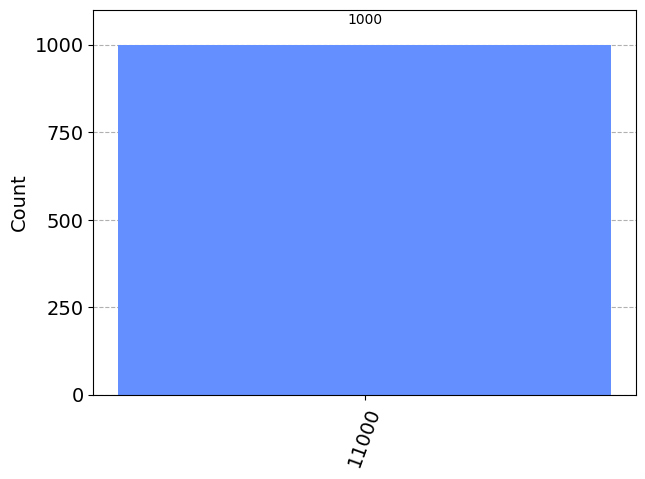

In [127]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)

![image](resources/mod_add.img)

In [7]:
def modular_adder_gate(a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.gate:
    """Returns the modular adder gate. The Gate requiers 2 + len(a_bin) + 1 Qubit. The first two Qubits are both control Qubits, the last one is an anciallary Qubit which needs to be in state |0> in the beginning.

    Parameters:
    a_bin: list[int]
        Binary representation of the classically summand a. The first element of the list needs to be the Least significant Bit & the last element the Most significant Bit. Example [0,0,0,1] to represent the decimal number 8.
    N_bin: list[int]
        Binary representation of the Moduland N / the Prime Factor. The first element of the list needs to be the Least significant Bit & the last element the Most significant Bit. Example [0,0,0,1] to represent the decimal number 8.

    Returns:  modular adder gate
    """
    modular_adder_gate = qiskit.QuantumCircuit(2 + len(a_bin) + 1) # 2 Control Qubits + qubits for the input + ancillary qubit
    modular_adder_gate.append(A_Gate(a_bin).control(2), [0,1] + list(range(2, len(a_bin)+2)))
    modular_adder_gate.append(A_Gate(N_bin).inverse(), list(range(2, len(a_bin)+2)))
    myQFT(modular_adder_gate,list(reversed(range(2, len(a_bin)+2))),inverse = True)
    modular_adder_gate.cnot(len(a_bin)+1,len(a_bin)+2)
    myQFT(modular_adder_gate,list(reversed(range(2, len(a_bin)+2))))
    modular_adder_gate.append(A_Gate(N_bin).control(1), [len(a_bin)+2] + list(range(2, len(a_bin)+2)))
    modular_adder_gate.append(A_Gate(a_bin).inverse().control(2), [0,1] + list(range(2, len(a_bin)+2)))
    myQFT(modular_adder_gate,list(reversed(range(2, len(a_bin)+2))),inverse = True)
    modular_adder_gate.x(len(a_bin)+1)
    modular_adder_gate.cnot(len(a_bin)+1,len(a_bin)+2)
    modular_adder_gate.x(len(a_bin)+1)
    myQFT(modular_adder_gate,list(reversed(range(2, len(a_bin)+2))))
    modular_adder_gate.append(A_Gate(a_bin).control(2), [0,1] + list(range(2, len(a_bin)+2)))
    modular_adder_gate = modular_adder_gate.to_gate()
    modular_adder_gate.name = "Add " + str(binToDez(a_bin)) + " Mod " + str(binToDez(N_bin))
    return modular_adder_gate

In [136]:
qc = qiskit.QuantumCircuit(8,6)
qc.x(1)
qc.x(0)


qc.x(3)
qc.x(4)
qc.x(5)
qc.barrier()
mes = [6,5,4,3,2]
myQFT(qc,mes)
qc.append(modular_adder_gate([1,0,1,1,0],[1,1,1,1,0]),[0,1,2,3,4,5,6,7])
myQFT(qc,mes,inverse = True)
qc.barrier()
qc.measure(range(2,8),range(6))
qc.draw()

┌───┐ ░                                                                  »
q_0: ┤ X ├─░──────────────────────────────────────────────────────────────────»
     ├───┤ ░                                                                  »
q_1: ┤ X ├─░──────────────────────────────────────────────────────────────────»
     └───┘ ░                                                                  »
q_2: ──────░────────────────────────────────────────────────■─────────────────»
     ┌───┐ ░                                                │                 »
q_3: ┤ X ├─░──────────────────────────────■─────────────────┼─────────■───────»
     ├───┤ ░                              │                 │         │       »
q_4: ┤ X ├─░────────────────■─────────────┼────────■────────┼─────────┼───────»
     ├───┤ ░                │       ┌───┐ │        │P(π/2)  │         │P(π/4) »
q_5: ┤ X ├─░───────■────────┼───────┤ H ├─┼────────■────────┼─────────■───────»
     └───┘ ░ ┌───┐ │P(π/2)  │P(π/4) └───┘ │P(π/8)           │P(π/16)          »
q_6: ──────░─┤ H ├─■────────■─────────────■─────────────────■─────────────────»
           ░ └───┘                                                            »
q_7: ──────░──────────────────────────────────────────────────────────────────»
           ░                                                                  »
c: 6/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                        ┌────────────────┐»
«q_0: ───────────────────────────────────────────────────┤0               ├»
«                                                        │                │»
«q_1: ───────────────────────────────────────────────────┤1               ├»
«                                                   ┌───┐│                │»
«q_2: ──────■─────────────────■─────────────■───────┤ H ├┤2               ├»
«           │                 │       ┌───┐ │P(π/2) └───┘│                │»
«q_3: ──────┼────────■────────┼───────┤ H ├─■────────────┤3               ├»
«     ┌───┐ │        │P(π/2)  │P(π/4) └───┘              │  Add 13 Mod 15 │»
«q_4: ┤ H ├─┼────────■────────■──────────────────────────┤4               ├»
«     └───┘ │P(π/8)                                      │                │»
«q_5: ──────■────────────────────────────────────────────┤5               ├»
«                                                        │                │»
«q_6: ───────────────────────────────────────────────────┤6               ├»
«                                                        │                │»
«q_7: ───────────────────────────────────────────────────┤7               ├»
«                                                        └────────────────┘»
«c: 6/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                                      »
«q_0: ─────────────────────────────────────────────────────────────────»
«                                                                      »
«q_1: ─────────────────────────────────────────────────────────────────»
«     ┌───┐                                                            »
«q_2: ┤ H ├─■──────────────■───────────────────■───────────────────────»
«     └───┘ │P(-π/2) ┌───┐ │                   │                       »
«q_3: ──────■────────┤ H ├─┼─────────■─────────┼──────────────■────────»
«                    └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐ │        »
«q_4: ─────────────────────■─────────■─────────┼────────┤ H ├─┼────────»
«                                              │P(-π/8) └───┘ │P(-π/4) »
«q_5: ─────────────────────────────────────────■──────────────■────────»
«                                                                      »
«q_6: ─────────────────────────────────────────────────────────────────»


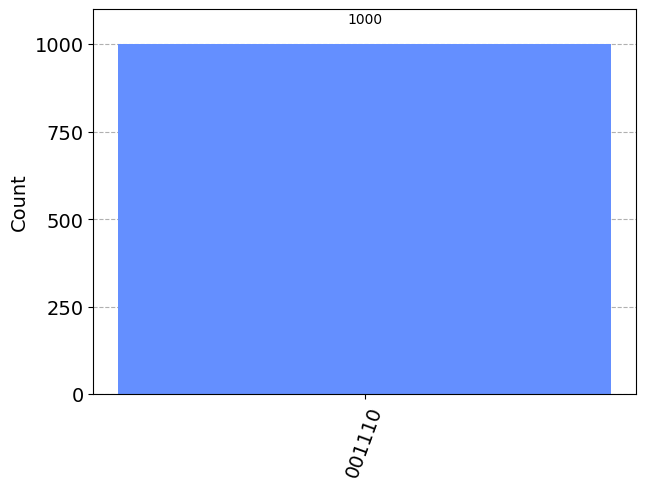

In [87]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)

![image](resources/cmult_img)

In [8]:
def cmult_gate(x_bits_amount: int,a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.gate:
    a_dez = binToDez(a_bin)
    N_dez = binToDez(N_bin)
    cmult_gate = qiskit.QuantumCircuit(1 + x_bits_amount + len(a_bin) + 1)
    myQFT(cmult_gate,list(reversed(range(1+x_bits_amount, 1 + x_bits_amount + len(a_bin)))))
    for i in range(1, len(a_bin)):
        a_i = ((2**(i - 1)) *  a_dez) % N_dez
        a_i_bin = dezToBin(a_i, len(a_bin))
        cmult_gate.append(modular_adder_gate(a_i_bin, N_bin), [0,i] + list(range(1+x_bits_amount, 1 + x_bits_amount + len(a_bin) + 1)))
    myQFT(cmult_gate,list(reversed(range(1+x_bits_amount, 1 + x_bits_amount + len(a_bin)))),inverse = True)
    cmult_gate = cmult_gate.to_gate()
    cmult_gate.name = "cmult " + str(a_dez) + " Mod " + str(N_dez)
    return cmult_gate

In [75]:
qc = qiskit.QuantumCircuit(11,10)
#qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
qc.x(4)

qc.x(5)
qc.x(6)
qc.x(7)
qc.x(8)
qc.append(cmult_gate(4,[1,1,1,0,0],[1,1,1,1,0]),range(11))


qc.measure(range(1,11),range(10))
qc.draw()

┌──────────────────┐                              
 q_0: ─────┤0                 ├──────────────────────────────
      ┌───┐│                  │┌─┐                           
 q_1: ┤ X ├┤1                 ├┤M├───────────────────────────
      ├───┤│                  │└╥┘┌─┐                        
 q_2: ┤ X ├┤2                 ├─╫─┤M├────────────────────────
      ├───┤│                  │ ║ └╥┘┌─┐                     
 q_3: ┤ X ├┤3                 ├─╫──╫─┤M├─────────────────────
      ├───┤│                  │ ║  ║ └╥┘┌─┐                  
 q_4: ┤ X ├┤4                 ├─╫──╫──╫─┤M├──────────────────
      ├───┤│                  │ ║  ║  ║ └╥┘┌─┐               
 q_5: ┤ X ├┤5  cmult 7 Mod 15 ├─╫──╫──╫──╫─┤M├───────────────
      ├───┤│                  │ ║  ║  ║  ║ └╥┘┌─┐            
 q_6: ┤ X ├┤6                 ├─╫──╫──╫──╫──╫─┤M├────────────
      ├───┤│                  │ ║  ║  ║  ║  ║ └╥┘┌─┐         
 q_7: ┤ X ├┤7                 ├─╫──╫──╫──╫──╫──╫─┤M├─────────
      ├───┤│                  │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
 q_8: ┤ X ├┤8                 ├─╫──╫──╫──╫──╫──╫──╫─┤M├──────
      └───┘│                  │ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_9: ─────┤9                 ├─╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
           │                  │ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_10: ─────┤10                ├─╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
           └──────────────────┘ ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
c: 10/══════════════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                                0  1  2  3  4  5  6  7  8  9

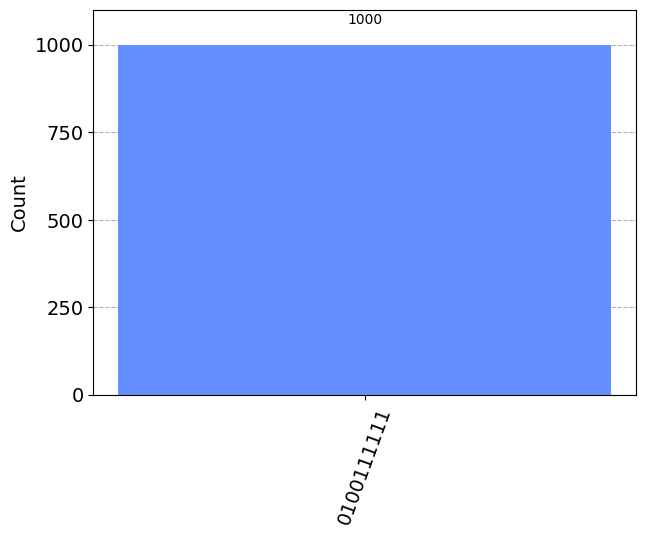

In [19]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)

![image.png](resources/ua.img)

In [9]:
def U_a_gate(x_bits_amount: int,a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.gate:
    U_a_gate = qiskit.QuantumCircuit(1 + x_bits_amount + len(a_bin) + 1)
    U_a_gate.append(cmult_gate(x_bits_amount,a_bin ,N_bin), range(1 + x_bits_amount + len(a_bin) + 1))
    for i in (range(1,x_bits_amount + 1)):
        U_a_gate.cswap(0,i,i+x_bits_amount)
    a_inv_bin = dezToBin(gcd(binToDez(a_bin),binToDez(N_bin)),len(a_bin))
    U_a_gate.append(cmult_gate(x_bits_amount,a_inv_bin ,N_bin).inverse(), range(1 + x_bits_amount + len(a_bin) + 1))
    U_a_gate = U_a_gate.to_gate()
    U_a_gate.name = "U_" + str(binToDez(a_bin))
    return U_a_gate
    
    
    
    

In [80]:
qc = qiskit.QuantumCircuit(11,10)
qc.x(0)
qc.x(1)
qc.x(2)
qc.x(4)
qc.append(U_a_gate(4,[1,0,1,1,0],[1,1,1,1,0]),range(11))
qc.measure(range(1,11),range(10))

qc.draw()

┌───┐┌────────┐                              
 q_0: ┤ X ├┤0       ├──────────────────────────────
      ├───┤│        │┌─┐                           
 q_1: ┤ X ├┤1       ├┤M├───────────────────────────
      ├───┤│        │└╥┘┌─┐                        
 q_2: ┤ X ├┤2       ├─╫─┤M├────────────────────────
      └───┘│        │ ║ └╥┘┌─┐                     
 q_3: ─────┤3       ├─╫──╫─┤M├─────────────────────
      ┌───┐│        │ ║  ║ └╥┘┌─┐                  
 q_4: ┤ X ├┤4       ├─╫──╫──╫─┤M├──────────────────
      └───┘│        │ ║  ║  ║ └╥┘┌─┐               
 q_5: ─────┤5  U_13 ├─╫──╫──╫──╫─┤M├───────────────
           │        │ ║  ║  ║  ║ └╥┘┌─┐            
 q_6: ─────┤6       ├─╫──╫──╫──╫──╫─┤M├────────────
           │        │ ║  ║  ║  ║  ║ └╥┘┌─┐         
 q_7: ─────┤7       ├─╫──╫──╫──╫──╫──╫─┤M├─────────
           │        │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
 q_8: ─────┤8       ├─╫──╫──╫──╫──╫──╫──╫─┤M├──────
           │        │ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_9: ─────┤9       ├─╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
           │        │ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_10: ─────┤10      ├─╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
           └────────┘ ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
c: 10/════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                      0  1  2  3  4  5  6  7  8  9

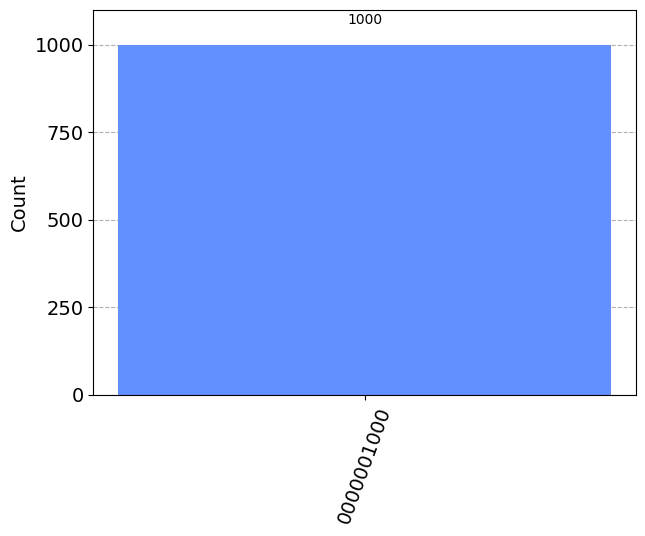

In [81]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)


In [51]:
a = 7
N = 15
n = 4
N_COUNT = 8
qc = qiskit.QuantumCircuit(4*n+2,N_COUNT) # 4*n+2 size for complete input bits, 2*n (N_COUNT) size of the control qubits which will also be measured
for h in range(N_COUNT):
    qc.h(h)
qc.x(N_COUNT)
for control in range(N_COUNT):
    qc.append(U_a_gate(n,dezToBin(modular_exponentiation(a, 2**control, N),n+1),dezToBin(N,n+1)),[control] + list(range(N_COUNT,4*n+2)))
myQFT(qc,list(reversed(range(0,8))),inverse = True,swaps = True)
qc.measure(range(N_COUNT),range(N_COUNT))
qc.draw()

┌───┐┌───────┐                                                      »
 q_0: ┤ H ├┤0      ├──────────────────────────────────────────────────────»
      ├───┤│       │┌───────┐                                             »
 q_1: ┤ H ├┤       ├┤0      ├─────────────────────────────────────────────»
      ├───┤│       ││       │┌───────┐                                    »
 q_2: ┤ H ├┤       ├┤       ├┤0      ├───────────────────────────────X────»
      ├───┤│       ││       ││       │┌───────┐                      │    »
 q_3: ┤ H ├┤       ├┤       ├┤       ├┤0      ├─────────────X────────┼────»
      ├───┤│       ││       ││       ││       │┌───────┐    │        │    »
 q_4: ┤ H ├┤       ├┤       ├┤       ├┤       ├┤0      ├────X────────┼────»
      ├───┤│       ││       ││       ││       ││       │┌───────┐    │    »
 q_5: ┤ H ├┤       ├┤       ├┤       ├┤       ├┤       ├┤0      ├────X────»
      ├───┤│       ││       ││       ││       ││       ││       │┌───────┐»
 q_6: ┤ H ├┤       ├┤       ├┤       ├┤       ├┤       ├┤       ├┤0      ├»
      ├───┤│       ││       ││       ││       ││       ││       ││       │»
 q_7: ┤ H ├┤       ├┤       ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│       ││       ││       ││       ││       ││       ││       │»
 q_8: ┤ X ├┤1      ├┤1      ├┤1      ├┤1      ├┤1      ├┤1      ├┤1      ├»
      └───┘│   U_7 ││       ││       ││       ││       ││       ││       │»
 q_9: ─────┤2      ├┤2  U_4 ├┤2      ├┤2      ├┤2      ├┤2      ├┤2      ├»
           │       ││       ││   U_1 ││       ││       ││       ││       │»
q_10: ─────┤3      ├┤3      ├┤3      ├┤3  U_1 ├┤3      ├┤3      ├┤3      ├»
           │       ││       ││       ││       ││   U_1 ││       ││       │»
q_11: ─────┤4      ├┤4      ├┤4      ├┤4      ├┤4      ├┤4  U_1 ├┤4      ├»
           │       ││       ││       ││       ││       ││       ││   U_1 │»
q_12: ─────┤5      ├┤5      ├┤5      ├┤5      ├┤5      ├┤5      ├┤5      ├»
           │       ││       ││       ││       ││       ││       ││       │»
q_13: ─────┤6      ├┤6      ├┤6      ├┤6      ├┤6      ├┤6      ├┤6      ├»
           │       ││       ││       ││       ││       ││       ││       │»
q_14: ─────┤7      ├┤7      ├┤7      ├┤7      ├┤7      ├┤7      ├┤7      ├»
           │       ││       ││       ││       ││       ││       ││       │»
q_15: ─────┤8      ├┤8      ├┤8      ├┤8      ├┤8      ├┤8      ├┤8      ├»
           │       ││       ││       ││       ││       ││       ││       │»
q_16: ─────┤9      ├┤9      ├┤9      ├┤9      ├┤9      ├┤9      ├┤9      ├»
           │       ││       ││       ││       ││       ││       ││       │»
q_17: ─────┤10     ├┤10     ├┤10     ├┤10     ├┤10     ├┤10     ├┤10     ├»
           └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
 c: 8/════════════════════════════════════════════════════════════════════»
                                                                          »
«                  ┌───┐                                                  »
« q_0: ──────────X─┤ H ├─■──────────────■───────────────────■─────────────»
«                │ └───┘ │P(-π/2) ┌───┐ │                   │             »
« q_1: ────X─────┼───────■────────┤ H ├─┼─────────■─────────┼─────────────»
«          │     │                └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐»
« q_2: ────┼─────┼──────────────────────■─────────■─────────┼────────┤ H ├»
«          │     │                                          │P(-π/8) └───┘»
« q_3: ────┼─────┼──────────────────────────────────────────■─────────────»
«          │     │                                                        »
« q_4: ────┼─────┼────────────────────────────────────────────────────────»
«          │     │                                                        »
« q_5: ────┼─────┼────────────────────────────────────────────────────────»
«          │     │                                                        »
« q_6: ────X─────┼────────────────────────────────────

In [10]:
def Shor(a: int, N: int,n: int, N_COUNT: int,number_shots: int = 1024, backend: str = 'aer_simulator'):
    qc = qiskit.QuantumCircuit(4*n+2,N_COUNT) # 4*n+2 size for complete input bits, 2*n (N_COUNT) size of the control qubits which will also be measured
    for h in range(N_COUNT):
        qc.h(h)
    qc.x(N_COUNT)
    for control in range(N_COUNT):
        qc.append(U_a_gate(n,dezToBin(modular_exponentiation(a, 2**control, N),n+1),dezToBin(N,n+1)),[control] + list(range(N_COUNT,4*n+2)))
    myQFT(qc,list(reversed(range(0,8))),inverse = True,swaps = True)
    qc.measure(range(N_COUNT),range(N_COUNT))
    simulator = qiskit.Aer.get_backend(backend)
    sim_result = qiskit.execute(qc, backend=simulator, shots=number_shots).result()
    return sim_result.get_counts(qc)

In [11]:
def calculate_primfactors_Shor(N, sequential = False):
    if N % 2 == 0:
        print("primfaktors: [" + str(2) +", " + str(N//2) + "]")
        return 0
    else:
        while True:
            a = randint(3, N)
            if math.gcd(a,N) != 1:
                print("primfaktors: [" + str(math.gcd(a,N)) +", " + str(N//math.gcd(a,N)) + "]")
                return 0
            else:
                n = math.ceil(math.log2(N))
                N_COUNT = 2*n
                if sequential:
                    counts_result = Shor_sequential(a,N,n,N_COUNT)
                    print("sequential")
                else:
                    counts_result = Shor(a,N,n,N_COUNT)
                peaks = []
                for count in counts_result.items():
                    if count[1] > 5: #Threshold
                        decimal = int(count[0], 2)
                        peaks.append([decimal, decimal/(2**N_COUNT)])
                for peak in peaks:
                    frac = Fraction(peak[1]).limit_denominator(N)
                    if frac.denominator % 2 == 0 :
                        guesses = [math.gcd(a**(frac.denominator//2)-1, N), math.gcd(a**(frac.denominator//2)+1, N)]
                        if guesses[0] != 1 and guesses[0] != N:
                            print("primfaktors by Shor: [" + str(guesses[0]) +", " + str(N//guesses[0]) + "]")
                            return counts_result
                        elif guesses[1] != 1 and guesses[1] != N:
                            print("primfaktors by Shor: [" + str(guesses[1]) +", " + str(N//guesses[1]) + "]")
                            return counts_result
                continue
    
    

sequential
primfaktors by Shor: [3, 5]


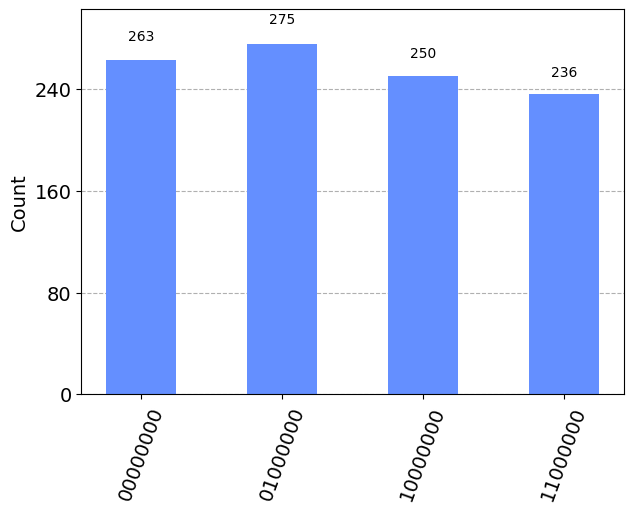

In [176]:
counts = calculate_primfactors_Shor(15,True)
plot_histogram(counts)


sequential
primfaktors by Shor: [7, 3]


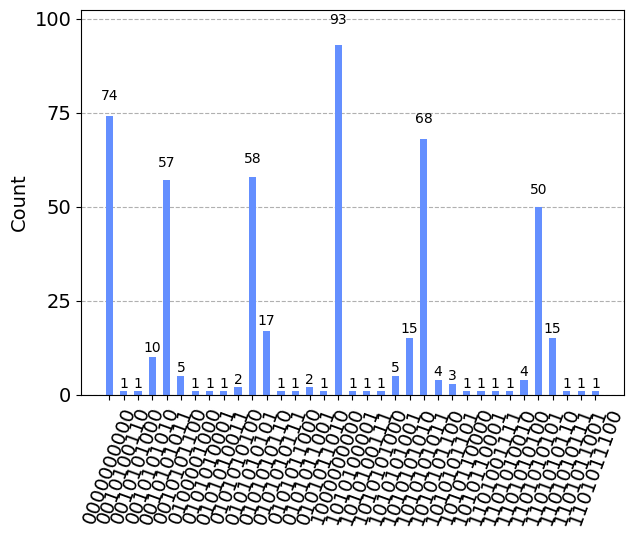

In [17]:
counts = calculate_primfactors_Shor(21,sequential = True)
plot_histogram(counts)

In [ ]:
current_time = datetime.datetime.now()
time_stamp = current_time.timestamp()
counts = calculate_primfactors_Shor(143,True)
current_time = datetime.datetime.now()
time_stamp_later = current_time.timestamp()
print("seconds: " + str(int(time_stamp_later - time_stamp)))
plot_histogram(counts)

primfaktors by Shor: [7, 5]
seconds: 1032


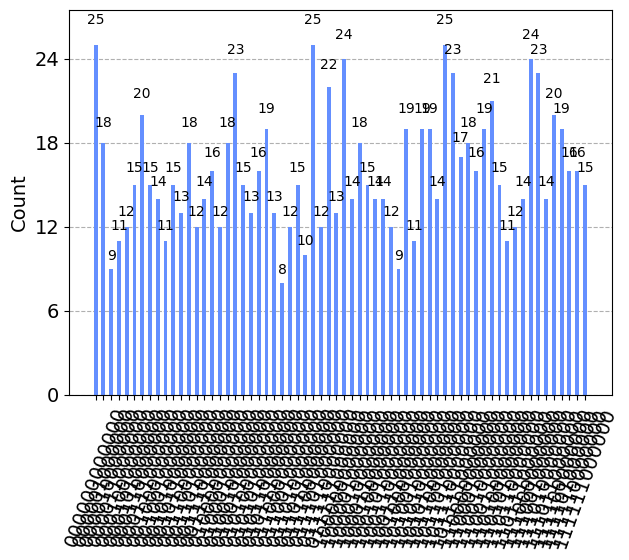

In [179]:
current_time = datetime.datetime.now()
time_stamp = current_time.timestamp()
counts = calculate_primfactors_Shor(35,False)
current_time = datetime.datetime.now()
time_stamp_later = current_time.timestamp()
print("seconds: " + str(int(time_stamp_later - time_stamp)))
plot_histogram(counts)

In [12]:
def R_gate(index,qc,creg,controlling_qubit):
    if index == 0:
        qc.h(controlling_qubit)
    else:
        for i in list(reversed(range(index))):
            qc.p((-pi/(2**(i+1))),controlling_qubit).c_if(creg[index - (i+1)],1)
        qc.h(controlling_qubit)

In [13]:
def Shor_sequential(a: int, N: int,n: int, N_COUNT: int,number_shots: int = 500, backend: str = 'aer_simulator'):
    controlling_qubit = qiskit.QuantumRegister(1, "c_qubit")
    qreg = qiskit.QuantumRegister(2*n+2, "qreg")
    creg = qiskit.ClassicalRegister(2*n, "creg")
    qc = qiskit.QuantumCircuit(controlling_qubit, qreg,creg) 
    qc.x(1)
    for control in range(N_COUNT):
        qc.h(0)
        qc.append(U_a_gate(n,dezToBin(modular_exponentiation(a, 2**(N_COUNT - control - 1), N),n+1),dezToBin(N,n+1)),[0] + list(range(1,2*n+3)))
        R_gate(control,qc,creg,controlling_qubit)
        qc.measure(controlling_qubit,creg[control])
        qc.x(0).c_if(creg[control],1)
    #return qc
    simulator = qiskit.Aer.get_backend(backend)
    sim_result = qiskit.execute(qc, backend=simulator, shots=number_shots).result()
    return sim_result.get_counts(qc)

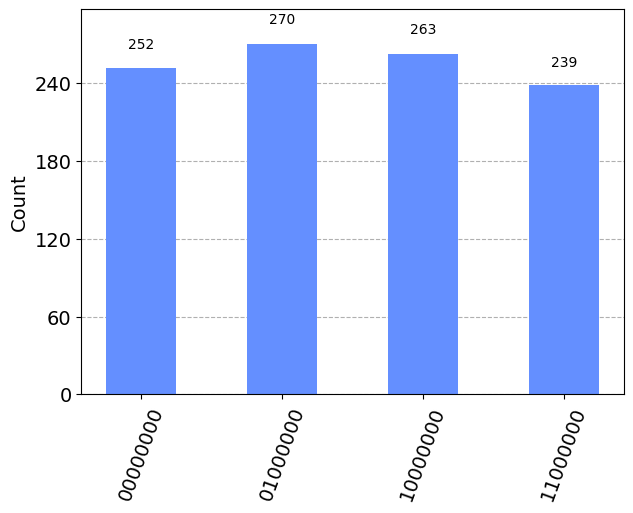